In [1]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

In [2]:
using ConfParser
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)
md_fname = "h4_sto3g_070625%1912.hdf5"
#md_fname = "h2o_sto3g_032024%0918.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname, uhf=true)

conf = ConfParse("../configs/pyscf_configs/h4_stretch.ini")
#conf = ConfParse("../configs/pyscf_configs/h2o_stretch_sto3g.ini")

parse_conf!(conf)
bond_lengths = parse.(Float64, retrieve(conf, "GEOMETRIES", "xyz_files")); # H6 bond sep = sqrt(2)*radial distance

In [3]:
#TEST TO ENSURE CORRECT CHEMICAL DATA LOADED
# Choose a bond length:
n_x = 8
println("r = $(bond_lengths[n_x]) Angstrom")
chemical_data = chemical_data_list[n_x]
PrintChemData(chemical_data)

r = 0.85 Angstrom
Molecule name: h4
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h4_stretch/0.85.xyz
XHF energy: -1.776743897250726
FCI energy: -1.7953086922741823


In [17]:
#USE THE FCI DATA TO CONSTRUCT AN "OPTIMAL" ORDERING BASED ON MUTUAL INFORMATION
# IF RUNNING UHF OR DIDNT DO FCI USE THE NEXT CELL


# Visualize the mutual information and calculate a "quasi-optimal" ordering:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", chemical_data.N_spt), cutoff=1e-16, maxdim=2^16);

print(fci_array)

S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
#print(Ipq)
OrbitalGraphPlot(Ipq, multiplier=2e1)

gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=0.8
)

opt_ord = InfDistAnnealing(
    Ipq, 
    1,                                                           
    gp,
    verbose=true
)[1]

#opt_ord = [1,2,3,4,5,6]

println("Quasi-optimal ordering: $(opt_ord)")
OrbitalGraphPlot(GraphMat(opt_ord, directed=false), multiplier=2.0)

BoundsError: BoundsError: attempt to access 2×2 Matrix{Float64} at index [3, 1]

In [4]:
#TO CONSTRUCT THE MPS FOR A UHF BASIS USING YOUR CHEMICAL INTUITION (no pressure)

# obtain occupation information:
num_mps_sites = chemical_data_list[1].N_spt

N = num_mps_sites  # total spin orbitals
#initialize the mps
sites = siteinds("Electron", N; conserve_qns=false)
function uhf_to_mps(alpha_occ, beta_occ, sites)
    state = Vector{String}(undef, length(sites))
    quarter = div(length(sites), 4)
    for i in 1:length(sites)
      if i <= quarter
        println("emp")
        state[i] = "Emp"
      elseif i <= 2*quarter
        println("up")
        state[i] = "Up"
      elseif i <= 3*quarter
        println("dn")
        state[i] = "Dn"
      else
        println("emp")
        state[i] = "Emp"

      end
      """ for spatial orbitals
      has_alpha = i in alpha_occ
      has_beta = i in beta_occ
      if has_alpha && has_beta
        state[i] = "UpDn"
      elseif has_alpha
        state[i] = "Up"
      elseif has_beta
        state[i] = "Dn"
      else
        state[i] = "Emp"
      end
      """
    end
    return productMPS(sites, state)
  end
  
mps = uhf_to_mps(chemical_data_list[1].alpha_occ_string, chemical_data_list[1].beta_occ_string, sites)


emp
emp
up
up
dn
dn
emp
emp


MPS
[1] ((dim=4|id=515|"Electron,Site,n=1"), (dim=1|id=597|"Link,l=1"))
[2] ((dim=1|id=597|"Link,l=1"), (dim=4|id=382|"Electron,Site,n=2"), (dim=1|id=156|"Link,l=2"))
[3] ((dim=1|id=156|"Link,l=2"), (dim=4|id=534|"Electron,Site,n=3"), (dim=1|id=457|"Link,l=3"))
[4] ((dim=1|id=457|"Link,l=3"), (dim=4|id=790|"Electron,Site,n=4"), (dim=1|id=743|"Link,l=4"))
[5] ((dim=1|id=743|"Link,l=4"), (dim=4|id=948|"Electron,Site,n=5"), (dim=1|id=989|"Link,l=5"))
[6] ((dim=1|id=989|"Link,l=5"), (dim=4|id=276|"Electron,Site,n=6"), (dim=1|id=956|"Link,l=6"))
[7] ((dim=1|id=956|"Link,l=6"), (dim=4|id=479|"Electron,Site,n=7"), (dim=1|id=847|"Link,l=7"))
[8] ((dim=1|id=847|"Link,l=7"), (dim=4|id=985|"Electron,Site,n=8"))


In [5]:
# The optimization parameters:
op1 = OptimParameters(
    maxiter=1, 
    numloop=1,  
    thresh="projection",
    eps=1e-12,
    sd_thresh="projection", 
    sd_eps=1.0e-12,
    delta=[1e-6,1e-7], # QPU noise
    noise=[0.0], # DMRG "noise" term
    sd_method="triple_geneig",
    sd_dtol=5e-3,
    sd_etol=1e-3
)

chi = 4
M_max = 4

# Messing around with noise parameters, the energy tolerance threshold, \\
# ...and the sweep number can boost performance in the parameter count

#delta_list = [[0.0,0.0] for M=2:M_max] # Noiseless
#delta_list = [[1e-7,1e-8], [1e-9,1e-10], [1e-11,1e-12]] # Light QPU noise
delta_list = [[1e-4,1e-5] for M=2:M_max] # Heavy QPU noise
etol_list = [2e-3,1e-3,5e-4,2e-4,1e-4,5e-5]
#numsweeps = [4, 12] # 4 single-MPS optim sweeps and 2*12=24 multi-MPS optim sweeps
numsweeps = [4, 6] # 4 single-MPS optim sweeps and 2*6=12 multi-MPS optim sweeps

2-element Vector{Int64}:
 4
 6

In [6]:
# Random initial ordering sometimes works even better than the Ipq-heuristic ordering:
#opt_ord = randperm(chemical_data.N_spt)

tnqe0 = GenSubspace(
    chemical_data, 
    M=1, 
    mps_maxdim=chi, 
    ham_tol=1e-12,
    perm_tol=1e-12,
    thresh="projection", 
    init_ord = [4,3,1,2,6,5,7,8],
    eps=1e-12, 
    sweep_num=20, 
    sweep_noise=(1e-8,1e-8,1e-8),
    dmrg_init=true,
    ovlp_opt=true,
    ovlp_weight=2.0,
    verbose=true
);


Generating Hamiltonian MPO:
4(4, 4, 4, 4)8
Done!


Generating Hamiltonian sparse matrix:
Contraction resulted in ITensor with 15 indices, which is greater
            than or equal to the ITensor order warning threshold 14.
            You can modify the threshold with macros like `@set_warn_order N`,
            `@reset_warn_order`, and `@disable_warn_order` or functions like
            `ITensors.set_warn_order(N::Int)`, `ITensors.reset_warn_order()`, and
            `ITensors.disable_warn_order()`.

Stacktrace:
  [1] backtrace()
    @ Base ./error.jl:114
  [2] _contract(A::ITensor, B::ITensor)
    @ ITensors ~/.julia/packages/ITensors/KvHvB/src/tensor_operations/tensor_algebra.jl:20
  [3] contract(A::ITensor, B::ITensor)
    @ ITensors ~/.julia/packages/ITensors/KvHvB/src/tensor_operations/tensor_algebra.jl:74
  [4] *
    @ ~/.julia/packages/ITensors/KvHvB/src/tensor_operations/tensor_algebra.jl:61 [inlined]
  [5] BottomRF
    @ ./reduce.jl:86 [inlined]
  [6] _foldl_impl
    @ ./re

In [7]:
#rotypes = ["none","none","none"]
#rotypes = ["fswap","fswap","fswap"]
rotypes = ["givens","givens","givens"]


tnqe3_evec_full = []
tnqe3_evec = []
tnqe3_pvec = []
tnqe3_cvec = []

tnqe3 = deepcopy(tnqe0)

push!(tnqe3_evec, tnqe3.E[1])
push!(tnqe3_evec_full, tnqe3.E[1])
push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))

tot_calls = 0

for k=1:M_max-1
    
    op1.delta = [delta_list[k][1],delta_list[k][2]]
    op1.sd_etol = etol_list[k]
    
    AddStates!(
        tnqe3;
        M_new=1,
        G_init="last",
        dmrg_init=(k==1),
        ovlp_opt=true,
        ovlp_weight=2.0,
        verbose=false
    )
    
    # Permute so new states are at the front:
    perm = circshift(collect(1:tnqe3.mparams.M), 1)
    
    ShuffleStates!(tnqe3, perm=perm, no_rev=true)
    
    println("\n$(tnqe3.mparams.M) states:\n")
    
    for l=1:numsweeps[1]
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=vcat([2], [0 for i=2:tnqe3.mparams.M]),
            rotype=rotypes[1],
            jperm=vcat([1], shuffle(2:tnqe3.mparams.M)),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        
    end
    
    for l=1:numsweeps[2]
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[2],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
        perm = randperm(tnqe3.mparams.M)
        ShuffleStates!(tnqe3, perm=perm, no_rev=true)
        
        tot_calls += TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=[2 for i=1:tnqe3.mparams.M],
            rotype=rotypes[3],
            jperm=collect(1:tnqe3.mparams.M),
            return_calls=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        ShuffleStates!(tnqe3, perm=invperm(perm), no_rev=true)
        
    end
    
    push!(tnqe3_evec, tnqe3.E[1])
    push!(tnqe3_pvec, CountNonZeros(tnqe3.phi_list))
    push!(tnqe3_cvec, tot_calls)
    println("\nTotal QPU calls = $(tot_calls)\n")
    
end

"""
nomps_evec = deepcopy(tnqe3_evec)
nomps_evec_full = deepcopy(tnqe3_evec_full)
nomps_pvec = deepcopy(tnqe3_pvec)

fswap_evec = deepcopy(tnqe3_evec)
fswap_evec_full = deepcopy(tnqe3_evec_full)
fswap_pvec = deepcopy(tnqe3_pvec)

"""

givens_evec3 = deepcopy(tnqe3_evec)
givens_evec3_full = deepcopy(tnqe3_evec_full)
givens_pvec3 = deepcopy(tnqe3_pvec)
givens_cvec3 = deepcopy(tnqe3_cvec)


[-4.889674372562098 0.0; 0.0 -5.16241625449151]
[1.0000000000000002 0.0; 0.0 1.0000000000000004]
[-5.16241625449151 0.0; 0.0 -4.889674372562098]
[1.0000000000000004 0.0; 0.0 1.0000000000000002]

2 states:

[-5.16241625449151 0.0; 0.0 -4.889674372562098]
[1.0000000000000004 0.0; 0.0 1.0000000000000002]
[-4.184882043611566 -9.841138204407252e-5 1.5798811152367802e-5 3.114021402326929e-5 -9.976053824287186e-5 0.0028900732457247565 8.264001673682233e-5; -5.032395035521935e-5 -2.294181365979769 -0.07038996152549049 -0.005064178021467656 0.0028758572388151655 -1.4562498982313875e-5 9.469788350346279e-5; 8.014354889767809e-5 -0.07025410049233492 -5.147224003179534 0.00014485632511614 0.015869591178485045 0.00021204724941425312 -5.12932219937491e-5; -9.185288429972133e-5 -0.004886895481412217 1.8833570286075373e-5 -3.777414527563135 0.2927817588496498 0.00021939980099036074 0.00016512504966167765; 5.3441095150684734e-5 0.0028540527180507067 0.016073799490015632 0.2927659028841152 -5.0813541497

Excessive output truncated after 524303 bytes.

 -4.243979052247748e-6 0.00021540786054246019 -0.00013238670873728204; 0.00013789454704381422 -0.00016774171366101196 -6.997235231637814e-5 -0.08364665813038126 0.0003391751190983576 -0.0003367095192340032 5.3712739194317285e-5 -2.772955825286207 -0.14300079814339478 0.16190180328007228 0.00014261271228060027 0.0007049145386240463 6.717044691052144e-5 -9.760162886444317e-5 0.00026299727279787826 0.00014935115253612 -2.515263913230573e-5; 7.043621343948832e-5 -4.5182454760330517e-5 -0.00011848897335381712 -0.10497492949148438 0.0009462281316219126 -0.00023553357989817628 6.8927953428447076e-6 -0.14296133372473185 -4.385782157726653 0.08402805657492216 -4.4760466063078686e-5 -0.0004519648911191875 0.00015648078275846795 -5.756042689572893e-6 0.0001709856110516895 3.256598648159518e-5 -0.00013606631757878777; -5.834443185873749e-5 -5.29891872539479e-5 5.638985761885344e-6 0.13641772362997795 -4.340882558917614e-5 0.0008196359372863905 -8.16483131101052e-5 0.16190042978612976 0.08401110300

3-element Vector{Any}:
  81678
 322674
 824346

In [8]:
CountNonZeros(tnqe3.phi_list)

296

In [9]:
using Dates
xvals = 1:length(tnqe3_evec_full)

yvals1 = tnqe3_evec_full .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals2 = nomps3_evec_full .+ (nomps3.chem_data.e_nuc - nomps3.chem_data.e_fci)

vx = collect(0:9).*12 .+ 1

plt1 = plot(
    [0.0], 
    [0.0],  
    lw=2.5, 
    primary=false,
    xlabel="Optimization sweep", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    xticks=vx,
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.3, color=RGB(0.2,0.7,0.4), label="Chem. acc.")

plot!(
    xvals, 
    yvals1,  
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE"
)
#=
plot!(
    xvals, 
    yvals2, 
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS",
    ls=:dot
)
=#
savefig(plt1, pwd()*"/../plots/sweep_comparison_h4_stretch_0.85A_sto3g_$(Dates.today()).pdf")


"/Users/brandonschramm/Research/TNQE-Julia-copy/plots/sweep_comparison_h4_stretch_0.85A_sto3g_2025-07-11.pdf"

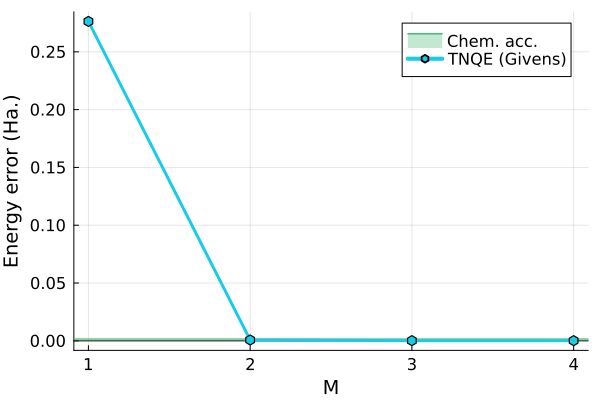

In [16]:
xvals = 1:M_max

#yvals1 = nomps_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals2 = fswap_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals3 = givens_evec3 .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
println(yvals3)
println("IM FUCKING PRINTING")
plt2 = plot(
    [1.0], 
    [0.0],  
    lw=2.5, 
    primary=false,
    xlabel="M", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.3, color=RGB(0.2,0.7,0.4), label="Chem. acc.")
#=
plot!(
    xvals, 
    yvals1, 
    markershape=:square,
    markersize=4.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS"
)

plot!(
    xvals, 
    yvals2, 
    markershape=:circle, 
    markersize=5.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE (FSWAP)", 
)
=#
println(yvals3)
plot!(
    xvals, 
    yvals3, 
    markershape=:hexagon, 
    markersize=5.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.1,0.8,0.9),
    label="TNQE (Givens)"
)

#display(plt2)

#savefig(plt2, pwd()*"/../plots/M_comparison_h4_stretch_0.85A_sto3g_$(Dates.today()).pdf")


In [17]:
println(yvals3)

In [19]:
chi=4

dmrg3_evec = []
dmrg3_pvec = []

dmrg3 = deepcopy(tnqe0)

push!(dmrg3_evec, dmrg3.E[1])
push!(dmrg3_pvec, CountNonZeros(dmrg3.phi_list))

for k=1:12
    
    dmrg3.mparams.mps_maxdim = chi+k
    
    dflt_sweeps=Sweeps(
        20, 
        maxdim=dmrg3.mparams.mps_maxdim, 
        noise=(1e-3,1e-4,1e-6,1e-8,1e-10)
    )
    
    e_dmrg, phi_dmrg = dmrg(dmrg3.H_mpo, dmrg3.phi_list[1], dflt_sweeps)
    
    dmrg3.phi_list[1] = phi_dmrg
    
    push!(dmrg3_evec, e_dmrg)
    push!(dmrg3_pvec, CountNonZeros(dmrg3.phi_list))
    
end

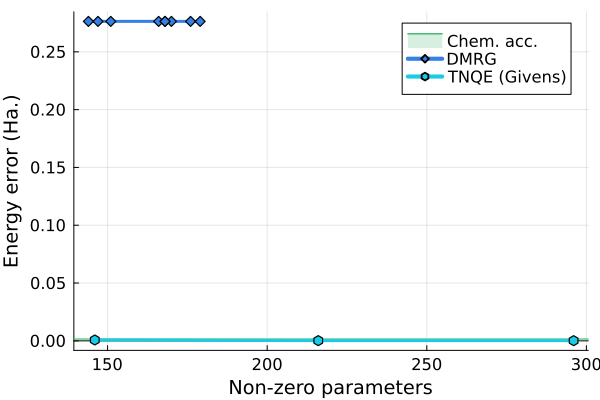

In [20]:
using Dates
using Plots

nx1 = [2,4]
nx2 = [5,13]

xvals1 = givens_pvec3[nx1[1]:nx1[2]]
xvals2 = dmrg3_pvec[nx2[1]:nx2[2]]
#xvals3 = fswap_pvec
#xvals4 = nomps_pvec

yvals1 = givens_evec3[nx1[1]:nx1[2]] .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals2 = dmrg3_evec[nx2[1]:nx2[2]] .+ (dmrg3.chem_data.e_nuc - dmrg3.chem_data.e_fci)
#yvals3 = fswap_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
#yvals4 = nomps_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)

plt3 = plot(
    [], 
    [],  
    lw=2.5, 
    primary=false,
    xlabel="Non-zero parameters", 
    ylabel="Energy error (Ha.)", 
    #title="Octahedral H6; STO-3G; 1.2A; m=3", 
    gridlinewidth=1.0,
    gridalpha=0.1,
    xguidefontsize=13,
    yguidefontsize=13,
    xtickfontsize=11,
    ytickfontsize=11,
    legendfontsize=11
)

hline!([0.0], color=RGB(0.0,0.0,0.0), primary=false)
#plot!(xvals, [0.0016 for x in xvals])
hline!([0.0016], lw=1.0, fillrange = [0.0], fillalpha=0.2, color=RGB(0.2,0.7,0.4), label="Chem. acc.")

plot!(
    xvals2, 
    yvals2, 
    markershape=:diamond, 
    markersize=5, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.2,0.5,0.9),
    label="DMRG"
)

"""
plot!(
    xvals4, 
    yvals4, 
    markershape=:square, 
    markersize=4.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.7,0.2),
    label="NOMPS"
)

plot!(
    xvals3, 
    yvals3, 
    markershape=:circle, 
    markersize=5.2, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(1.0,0.35,0.35),
    label="TNQE (FSWAP)"
)

"""

plot!(
    xvals1, 
    yvals1, 
    markershape=:hexagon, 
    markersize=5.0, 
    #markerstrokecolor=RGB(0.2,0.2,0.2),
    markerstrokewidth=1.5,
    lw=3.0, 
    color=RGB(0.1,0.8,0.9),
    label="TNQE (Givens)"
)

display(plt3)
print(yvals1)
#savefig(plt3, pwd()*"/../plots/nnz_comparison_h6_octahedron_1.2A_sto3g_$(Dates.today()).pdf")


In [ ]:
# Quicksave the data:

using Dates

fid = h5open(pwd()*"/../datasets/temp/h4_stretch_0.85A_sto3g_$(Dates.today()).h5", "w")

fid["tnqe_full"] = Float64.(tnqe3_evec_full)
fid["tnqe"] = Float64.(tnqe3_evec)
#fid["nomps_full"] = Float64.(nomps3_evec_full)
#fid["nomps"] = Float64.(nomps3_evec)

close(fid)

HDF5.API.H5Error: HDF5.API.H5Error: Error creating file /Users/brandonschramm/Research/TNQE-Julia-copy/notebooks/../datasets/temp/h2_stretch_1.2A_sto3g_2025-06-24.h5
libhdf5 Stacktrace:
 [1] H5FD__sec2_open: File accessibility/Unable to open file
     unable to open file: name = '/Users/brandonschramm/Research/TNQE-Julia-copy/notebooks/../datasets/temp/h2_stretch_1.2A_sto3g_2025-06-24.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602
  ⋮